Wir definieren hier zunächst mal die Fehler zum Zeitpunkt $t_0$.

In [66]:
import numpy as np

# ----------------------------------------------------------------------------------------------------------------------
# error vectors

dr=np.zeros((3, 1))
#dr[2]=10
#dr=np.random.randn(3,1)
#dr[0]=dr[0]*1e-6
#dr[1]=dr[1]*1e-6
dv=np.zeros((3, 1))
dv[1]=0.0
dv0=dv[1]
#dv=np.random.randn(3,1)
dpsi=np.zeros((3, 1))
#dpsi[0]=1e-5
#dpsi=np.random.randn(3,1)
da=np.zeros((3, 1))
#da[2]=1e-3
da=np.random.randn(3,1)*1e-6
dw=np.zeros((3, 1))
#dw[0]=1e-5
#dw=np.random.randn(3,1)*1e-6
dx=np.concatenate((dr,dv,dpsi,da,dw), axis=0)

print(dx)


[[ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.62332146e-07]
 [-5.48025399e-07]
 [-1.65142474e-06]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]


Jetzt legen wir Position, Geschwindigkeit und Beschleunigung fest 

In [67]:
# ----------------------------------------------------------------------------------------------------------------------
# input arrays of nominal values

# coordinates in ECEF system [[phi], [lambda], [h]] or [[lat], [lon], [height]], angles in rad!
r_e = np.zeros((3, 1))
r_e[0]=np.radians(48.78232) #coordinates of Stuttgart
r_e[1]=np.radians(9.17702) #coordinates of Stuttgart
r_e[2]=240  #coordinates of Stuttgart
phi = r_e[0, 0]
lamb = r_e[1, 0]
h = r_e[2, 0]


# velocity in n-system [[v_N], [v_E], [v_D]]
v_n = np.zeros((3, 1))


v_N = v_n[0, 0]
v_E = v_n[1, 0]
v_D = v_n[2, 0]

# acceleration in n-system [[a_N], [a_E], [a_D]]
a_n = np.zeros((3, 1))
a_N = a_n[0, 0]
a_E = a_n[1, 0]
a_D = a_n[2, 0]

RPY = np.zeros((3, 1))
#RYP = np.random.randn(3,1)
roll = RPY[0, 0]
pitch = RPY[1, 0]
yaw =RPY[2, 0]


Nun stellen wir die $\mathbf{F}$ Matrix auf

In [68]:



# ----------------------------------------------------------------------------------------------------------------------
# Constants (in meter)
a = 6378137.0
b = 6356752.3

def _M(phi_fix):
    M = (a*b)**2 / ((a*np.cos(phi_fix))**2 + (b*np.sin(phi_fix))**2)**(3/2)
    return M

def _N(phi_fix):
    N = a**2 / np.sqrt((a*np.cos(phi_fix))**2 + (b*np.sin(phi_fix))**2)
    return N

def _R(phi_fix):
    R = np.sqrt(((a**2 * np.cos(phi_fix))**2 + (b**2 * np.sin(phi_fix))**2)/((a*np.cos(phi_fix))**2 + (b*np.sin(phi_fix))**2))
    return R

M = _M(phi)
N = _N(phi)
R = _R(phi)

def g(h):
    g = -9.81*(R/(R+h))**2
    return g

# Rotation rate of earth [rad/s]
omega_E = 2*np.pi/86400


# ----------------------------------------------------------------------------------------------------------------------

lambdot=v_E/((N+h)* np.cos(phi))
phidot=v_N/(M+h)

# ----------------------------------------------------------------------------------------------------------------------
# Error equation for position

F_deltardot_deltar = np.array(
    [[0.0,                                           0.0, -v_N / (M + h)**2],
     [(v_E * np.tan(phi)) / ((N + h) * np.cos(phi)), 0.0, -v_E / ((N + h)**2 * np.cos(phi))],
     [0.0,                                           0.0,  0.0]]
)

F_deltardot_deltav = np.array(
    [[1 / (M + h),   0.0,                                    0.0],
     [0.0,           1.0 / ((N + h) * np.cos(phi)),          0.0],
     [0.0,           0.0,                                   -1.0]]
)

F_zero=np.zeros((3, 3))

F_r = np.concatenate((F_deltardot_deltar, F_deltardot_deltav,F_zero,F_zero,F_zero), axis=1)

# ----------------------------------------------------------------------------------------------------------------------
# Error equation for velocity

# Eq. (3.11) (h_1)


a_D=g(h)



F_deltavdot_deltapsi = np.array(
    [[0.0,   -a_D, a_E],
     [a_D,  0.0,  -a_N],
     [-a_E,  a_N,  0.0]]
)


# (h_2) F_deltavdot_deltaa is equal to C_p^n, from script INav VO04 Eq. (4.8) (body and p frame are here the same)
F_deltavdot_deltaa = np.array(
    [[np.cos(yaw)*np.cos(pitch), np.cos(yaw)*np.sin(pitch)*np.sin(roll) - np.sin(yaw)*np.cos(roll), np.cos(yaw)*np.sin(pitch)*np.cos(roll) + np.sin(yaw)*np.sin(roll)],
     [np.sin(yaw)*np.cos(pitch), np.sin(yaw)*np.sin(pitch)*np.sin(roll) + np.cos(yaw)*np.cos(roll), np.sin(yaw)*np.sin(pitch)*np.cos(roll) - np.cos(yaw)*np.sin(roll)],
     [-np.sin(pitch),            np.cos(pitch)*np.sin(roll),                                        np.cos(pitch)*np.cos(roll)]]
)
C_p_n = F_deltavdot_deltaa


# Eq. (3.13) (h_3)
F_deltavdot_deltav_1 = np.array(
    [[0.0, -(2*omega_E + lambdot)*np.sin(phi), phidot],
     [(2*omega_E + lambdot)*np.sin(phi),  0.0, (2*omega_E + lambdot)*np.cos(phi)],
     [-phidot,  -(2*omega_E + lambdot)*np.cos(phi), 0.0]]
)

# Eq. (3.19) (h_4)
F_deltavdot_deltar_1 = np.array(
    [[-v_E*(2*omega_E*np.cos(phi) + v_E/((N+h)*np.cos(phi)**2)) ,  0.0, -(v_D*v_N)/(M + h)**2 + v_E**2*np.tan(phi)/(N + h)**2],
     [2*omega_E *(v_N*np.cos(phi)-v_D*np.sin(phi))+v_E*v_N/((N+h)*np.cos(phi)**2), 0.0, -v_E/(N + h)**2*(v_D + v_N*np.tan(phi))],
     [2*v_E*omega_E*np.sin(phi) ,                                           0.0,  v_E**2/(N + h)**2 + v_N**2/(M + h)**2]]
)
F_deltavdot_deltav_2 = np.array(
    [[v_D/(M + h),  -(v_E*np.tan(phi))/(N + h),        0.0],
     [0.0,           (v_D+v_N*np.tan(phi))/(N + h), 0.0],
     [-v_N/(M + h), -v_E/(N + h),                      0.0]]
)

# Eq. (3.20) (h_5)
F_deltavdot_deltar_2 = np.array(
    [[0.0, 0.0,  0.0],
     [0.0, 0.0,  0.0],
     [0.0, 0.0, -2.0 * g(h) / (R+h)]]
)

F_deltavdot_deltar=F_deltavdot_deltar_1+F_deltavdot_deltar_2
F_deltavdot_deltav=F_deltavdot_deltav_1+F_deltavdot_deltav_2

F_v = np.concatenate((F_deltavdot_deltar, F_deltavdot_deltav,F_deltavdot_deltapsi,F_deltavdot_deltaa,F_zero), axis=1)


# ----------------------------------------------------------------------------------------------------------------------
# Error equation for orientation

# Omega_in_n is calculated using Eq. (3.12); omega_in^n = omega_ie^n + omega_en^n and Omega_in^n is skew-symmetric
# matrix of omega_in^n
Omega_in_n = np.array(
    [[0.0,                             (omega_E + lambdot)*np.sin(phi), -phidot],
     [-(omega_E + lambdot)*np.sin(phi),  0.0,                             -(omega_E + lambdot)*np.cos(phi)],
     [phidot,                         (omega_E + lambdot)*np.cos(phi), 0.0]]
)

# Eq. (3.32)
F_psidot_deltar = np.array(
    [[-omega_E*np.sin(phi),                                               0.0, -v_E/(N + h)**2],
     [0.0,                                                                0.0,  v_N/(M + h)**2],
     [-omega_E*np.cos(phi) - v_E/((N+h)*np.cos(phi)**2) , 0.0,  v_E*np.tan(phi)/(N + h)**2]]
)

# Eq. (3.32)
F_psidot_deltav = np.array(
    [[0.0,           1.0/(N + h),         0.0],
     [-1.0/(M + h),  0.0,                 0.0],
     [0.0,          -np.tan(phi)/(N + h), 0.0]]
)

F_psi = np.concatenate((F_psidot_deltar, F_psidot_deltav,-Omega_in_n,F_zero,-C_p_n), axis=1)

# Eq. (3.32)
tau=1000;
F_GaussMarkov = np.array(
    [[-1/tau,        0.0,         0.0],
     [0.0,  -1/tau,             0.0],
     [0.0,  0.0, -1/tau]]
)


#F_da = np.concatenate((F_zero,F_zero,F_zero,F_GaussMarkov,F_zero), axis=1)
#F_dw = np.concatenate((F_zero,F_zero,F_zero,F_zero,F_GaussMarkov), axis=1)

F_da = np.concatenate((F_zero,F_zero,F_zero,F_zero,F_zero), axis=1)
F_dw = np.concatenate((F_zero,F_zero,F_zero,F_zero,F_zero), axis=1)

F= np.concatenate((F_r,F_v,F_psi,F_da,F_dw), axis=0)



Wir interessieren uns wie sich ein Fehler über die Zeit auswirkt

In [69]:
from scipy import linalg
T_max=3600*24
dt=1
sol=np.zeros((15,T_max))
sol[:,0:1]=dx
Phi=linalg.expm(F*dt)
for i in range(1,T_max):
    dx_pred=Phi@dx
    sol[:,i:i+1]=dx_pred
    dx=dx_pred


Und plotten $\delta r$, $\delta v$ und $\psi$.

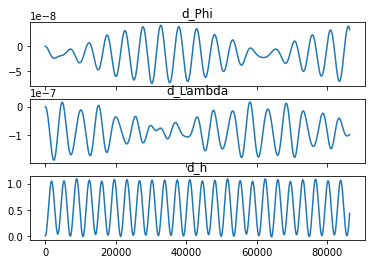

In [70]:
import matplotlib.pyplot as plt

f, (ax1, ax2,ax3) = plt.subplots(3, 1, sharex=True)
t=np.arange(0,T_max)*dt
ax1.plot(t, sol[0,:])
ax1.set_title('d_Phi')
ax2.plot(t, sol[1,:])
ax2.set_title('d_Lambda')
ax3.plot(t, sol[2,:])
ax3.set_title('d_h')
plt.show()

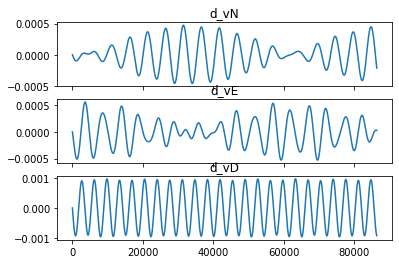

In [71]:
f, (ax1, ax2,ax3) = plt.subplots(3, 1, sharex=True)
t=np.arange(0,T_max)*dt
ax1.plot(t, sol[3,:])
ax1.set_title('d_vN')
ax2.plot(t, sol[4,:])
#ax2.plot(t, dv0*np.cos(t*np.sqrt(-g(h)/R)))
ax2.set_title('d_vE')
ax3.plot(t, sol[5,:])
ax3.set_title('d_vD')
plt.show()

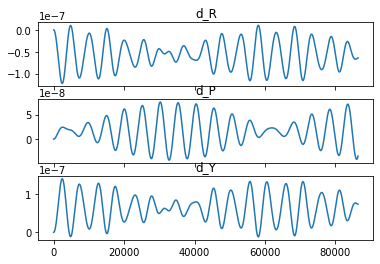

In [72]:
f, (ax1, ax2,ax3) = plt.subplots(3, 1, sharex=True)
t=np.arange(0,T_max)*dt
ax1.plot(t, sol[6,:])
#ax1.plot(t, 1e-5*np.cos(t*np.sqrt(-g(h)/R)))
ax1.set_title('d_R')
ax2.plot(t, sol[7,:])
ax2.set_title('d_P')
ax3.plot(t, sol[8,:])
ax3.set_title('d_Y')
plt.show()